In [1]:
from sklearn.datasets import make_classification
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score, brier_score_loss, f1_score, recall_score, precision_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

In [175]:
######################################
# A high-level calibrated classifier
######################################

def calibrated_fit(clf, X, y, n_splits=5, scoring="gini", stratify=False, calibrated_probs=True, random_state=None):
    
    assert hasattr(clf, "predict_proba"), "Classifier has no attribute predict_proba."

    trained_models, scores = [], {"train": [], "test": []}
    
    if calibrated_probs:
        clf = CalibratedClassifierCV(clf, cv=3)
    
    if stratify:
        kfold = StratifiedKFold(n_splits, shuffle=True, random_state=random_state)
    else:    
        kfold = KFold(n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, test_index) in enumerate(kfold.split(X, y)):

        X_train, y_train = X[train_index], y[train_index]
        X_test,  y_test =  X[test_index],  y[test_index]

        clf.fit(X_train, y_train)
        trained_models.append(clf)

        y_pred_train = clf.predict_proba(X_train)[:, 1] 
        train_scores = []
        
        for threshold in (.5, .6, .7, .8, .9):
        
            if scoring == "accuracy":
                train_score = accuracy_score(y_train, y_pred_train > threshold)
            elif scoring == "gini":
                train_score = 2 * roc_auc_score(y_train, y_pred_train > threshold) - 1
            elif scoring == "f1": 
                train_score = f1_score(y_train, y_pred_train > threshold)
            elif scoring == "precision":
                train_score = precision_score(y_train, y_pred_train > threshold)
            elif scoring == "recall":
                train_score = recall_score(y_train, y_pred_train > threshold)
            
            train_scores.append(train_score)
        
        scores["train"].append(train_scores)
        
        y_pred_test = clf.predict_proba(X_test)[:, 1] 
        test_scores = []
        
        for threshold in (.5, .6, .7, .8, .9):
            
            if scoring == "accuracy":
                test_score = accuracy_score(y_test, y_pred_test > threshold)        
            elif scoring == "gini":
                test_score = 2 * roc_auc_score(y_test, y_pred_test > threshold) - 1
            elif scoring == "f1": 
                test_score = f1_score(y_test, y_pred_test > threshold)
            elif scoring == "precision":
                test_score = precision_score(y_test, y_pred_test > threshold)
            elif scoring == "recall":
                test_score = recall_score(y_test, y_pred_test > threshold)
            
            test_scores.append(test_score)
        
        scores["test"].append(test_scores)            
        
        print(125 * "#")    
        print("# Training fold number %i:" % (fold + 1))
        print("Train scores: ", train_scores)
        print("Test  scores: ", test_scores)
        print(125 * "#")
        print()
    
    return trained_models, scores

def plot_calibration_curve(clf, X_test, y_test, y, name):

    fig = plt.figure(1, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    
    for clf, name in [(clf, name)]:
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:
            prob_pos = clf.decision_function(X_test)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
            
        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)    

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%1.3f)" % (name, clf_score))
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name, histtype="step", lw=2)

        ax1.set_ylabel("Fraction of positives")
        ax1.set_ylim([-0.05, 1.05])
        ax1.legend(loc="upper left")
        ax1.set_title('Calibration plots  (reliability curve)')

        ax2.set_xlabel("Mean predicted value")
        ax2.set_ylabel("Count")
        ax2.legend(loc="upper center", ncol=2)

        plt.tight_layout()
        
#################################################################
# Checking for consistency of predicted probabilities over time
#################################################################
        
def is_ordered(intervals):
    for i, j in zip(intervals[:-1], intervals[1:]):
        if not (i.right == j.left and j > i):
            return False
    return True

def verify_consistency(df, col, target, grouper, q=100, n=10, random_state=None):
    
    data = df.copy()
    data["aux"] = pd.qcut(data[col], q=q, duplicates="drop")
    grouped_aux = data.groupby(["aux", grouper]).agg({target: lambda x: 100 * x.sum() / len(x)})[::-1]

    s = len(grouped_aux.index.levels[1])
    buckets = grouped_aux.index.levels[0][::-1].tolist()
    
    bad_rates = pd.DataFrame(grouped_aux[target].values.reshape(-1, s))
    
    if bad_rates.shape != (len(buckets), s):
        return verify_consistency(df, col, target, grouper, q=(q-q//10), n=n)
    
    bad_rates["bucket"] = buckets
    bad_rates = bad_rates.sort_values("bucket").reset_index(drop=True)
    
    clf = KMeans(random_state=random_state, n_clusters=n)
    bad_rates["kmeans"] = clf.fit_predict(bad_rates.iloc[:, :-2], bad_rates["bucket"])
    
    intervals = []
    
    for group in bad_rates["kmeans"].unique():
        idx = np.where(bad_rates["kmeans"] == group)[0]
        left = bad_rates.loc[idx, "bucket"].min().left
        right = bad_rates.loc[idx, "bucket"].max().right
        intervals.append(pd.Interval(left, right))
        
    if not is_ordered(intervals):
        return verify_consistency(df, col, target, grouper, q=q, n=n-1)
    
    data["bucket"] = pd.cut(data[col], bins=pd.IntervalIndex(intervals))
    return data.groupby(["bucket", grouper]).agg({target: lambda x: 100 * x.sum() / len(x)}), pd.IntervalIndex(intervals)

def plot_consistency(df, target):
    
    fig, ax = plt.subplots(1, 1, figsize=(6, 8))
    labels = df.index.levels[1]
    s = len(labels)

    for n, (i, j) in enumerate(df.index):
        if n % s == 0:
            df.loc[i].plot(use_index=False, y=target, ax=ax, label=i, marker="o")

    ax.legend(title="Bucket", loc="upper right", bbox_to_anchor=(0.4, 0, 1, 1))        
    ax.set_ylabel("Bad Rate (%)", fontsize=12)
    ax.set_xticks(range(s))
    ax.set_xticklabels(labels)
    ax.set_title(target[0].upper() + target[1:].lower())

    return ax

###########################################
# Tools for splitting continuous variables
###########################################

def is_monotonic(x):
    
    """Checks if some array, x, is monotonic. Returns: boolean variable."""
    
    x = np.array(x)
    diff = x[1:] - x[:-1]
    return (diff <= 0).all() or (diff >= 0).all()

def recursive_outlier_intervals(x, intervals=[]):
    
    """
    Locates lower and upper-boundary outliers at first. Then recursively locates 
    upper-boundary outliers, adding their interquantile ranges (IQRs) to an interval array. 
    Returns: pd.IntervalIndex()."""
    
    if len(x) == 0:
        intervals[-2] = pd.Interval(intervals[-2].left, np.inf)
        return pd.IntervalIndex(intervals[:-1])
    
    if not hasattr(x, "quantile"):
        x = pd.Series(x)
        
    q1 = x.quantile(.25)
    q3 = x.quantile(.75)
    iqr = q3 - q1
    
    if len(intervals) == 0:
        intervals = [
            pd.Interval(-np.inf, q1 - 1.5 * iqr),
            pd.Interval(q1 - 1.5 * iqr, q3 + 1.5 * iqr),
            pd.Interval(q3 + 1.5 * iqr, np.inf)
        ]
    
    else:
        intervals = intervals[:-1] + [
            pd.Interval(intervals[-2].right, q3 + 1.5 * iqr),
            pd.Interval(q3 + 1.5 * iqr, np.inf)
        ]
    
    return recursive_outlier_intervals(x.loc[~pd.cut(x, bins=pd.IntervalIndex(intervals[-1:])).isnull()], intervals)

def get_bad_rates(x, y, name=""):
    
    """Builds a pandas DataFrame with bad rate percentage of y per distinct value of x. 
    Returns: a pandas DataFrame."""
    
    df = pd.DataFrame({name: x, "bad_rate": y})
    df["event"] = df["bad_rate"] == 1
    df["not_event"] = df["bad_rate"] == 0
    grouped = df.groupby(name).agg({"bad_rate": lambda x: 100 * x.sum() / len(x), "event": sum, "not_event": sum})
    grouped["total"] = grouped[["event", "not_event"]].sum(axis=1)
    return grouped.fillna(0)

def qcut_until_monotonic(x, y, q=10, labels=False, name=""):
    
    """Iteratively splits x into quantiles until it results in a monotonic behavior 
    with respect to bad rates. Returns: a pandas DataFrame."""
    
    rates = get_bad_rates(pd.qcut(x, q, labels=range(q) if labels else None), y, name)
    while not is_monotonic(rates["bad_rate"].values):
        q -= 1
        rates = get_bad_rates(pd.qcut(x, q, labels=range(q) if labels else None), y, name)
    return rates

#############################################################################################################################
# Training fold number 1:
Train scores:  [0.6301651821097243, 0.5659447300981977, 0.4952087250554198, 0.39501073182518653, 0.2582740156431451]
Test  scores:  [0.6357837323860085, 0.5670935435342692, 0.49635669074474875, 0.4006601264468095, 0.26942520102370304]
#############################################################################################################################

#############################################################################################################################
# Training fold number 2:
Train scores:  [0.6301837886648136, 0.5664205529584092, 0.4947773415202472, 0.39547345796111033, 0.2622577214768109]
Test  scores:  [0.6261201690094251, 0.5571542801067786, 0.490477016882384, 0.3875239320730275, 0.2479245585682317]
######################################################################################################

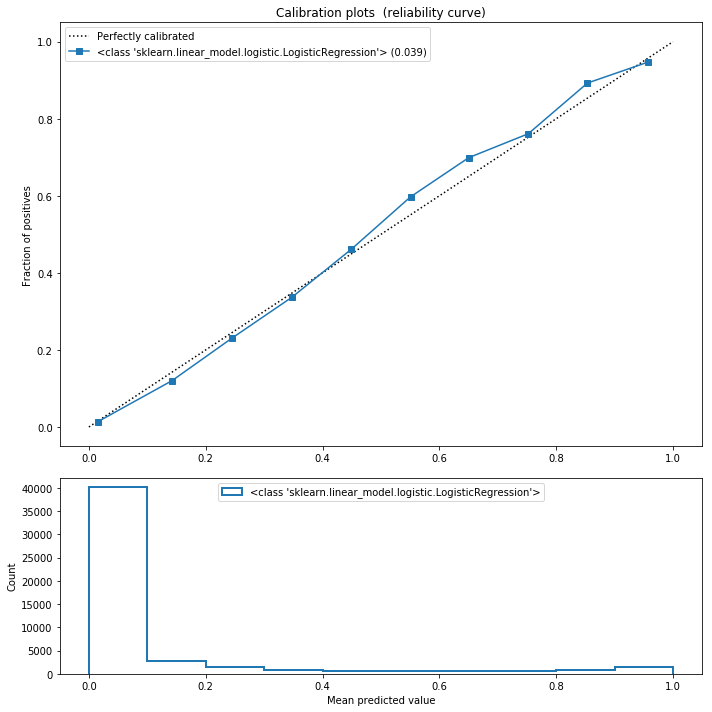

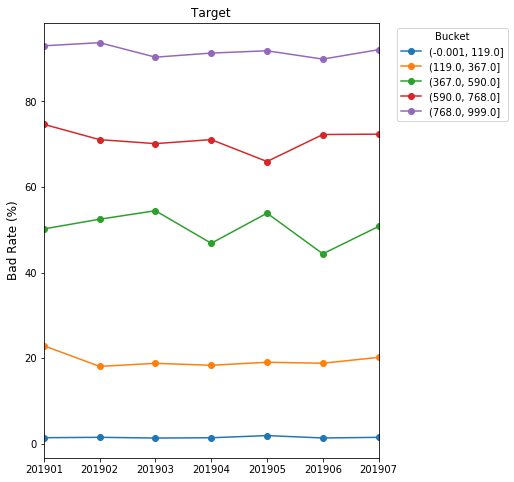

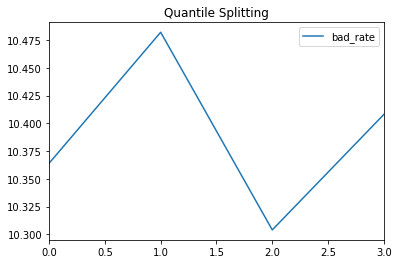

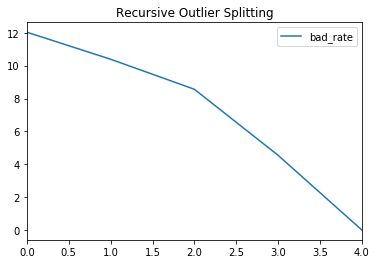

In [194]:
if __name__ == "__main__":

    X, y = make_classification(n_samples=200000, n_features=20, n_classes=2, weights=[.9, .1])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

    # Fitting a classifier with calibrated probabilities
    estimator = LogisticRegression(solver="lbfgs")
    clf, scores = calibrated_fit(estimator, X_train, y_train, 5, "gini", True, True, 0)

    # Printing train scores
    print("Average Train scores:", np.array(scores["train"]).mean(axis=1))

    # Printing test scores
    print("Average Test scores :", np.array(scores["test"]).mean(axis=1))

    # Selecting the top performer
    best_clf = clf[np.array(scores["test"]).mean(axis=1).argmax()]

    # Plotting the calibration curve on never seen data
    plot_calibration_curve(best_clf, X_test, y_test, y, estimator.__class__)
    
    # Checking for consistency over time on never seen data

    # Filling dataframe with predicted scores
    dataframe = pd.DataFrame({"target": y_test, "score": (1000 * best_clf.predict_proba(X_test)[:, 1]).astype(int)})

    # Randomizing some time-related variable for demonstration purposes only
    dataframe["date"] = np.random.choice(range(201901, 201908, 1), size=len(dataframe))

    # New dataframe with the most consistent score splits over time     
    df, intervals = verify_consistency(dataframe, "score", "target", "date", q=100, n=5, random_state=0)

    # Plotting split behavior with time
    plot_consistency(df, "target")
    
    # Demonstration of custom continuous variables splits
    df = pd.DataFrame(X, columns=["var%i" % i for i in range(1, X.shape[1] + 1)])
    df["target"] = y
    
    var = "var1"
    
    # Quantile splitting
    x = pd.qcut(df[var], q=4)
    x = pd.Categorical(x, ordered=True).codes
    plot_data = get_bad_rates(x, df["target"])
    plot_data.plot(use_index=True, y="bad_rate", title="Quantile Splitting")
    
    # Recursive outlier splitting
    bins = recursive_outlier_intervals(df[var])
    x = pd.cut(df[var], bins=bins)
    x = pd.Categorical(x, ordered=True).codes
    get_bad_rates(x, df["target"]).plot(use_index=True, y="bad_rate", title="Recursive Outlier Splitting")
    
    plt.show()